### setup and import

In [54]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, Sequence
import operator
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from langchain_community.tools import TavilySearchResults
from dotenv import load_dotenv
import os
import logging

# Set up logging
logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

# Load environment variables
try:
    load_dotenv()
except Exception as e:
    logger.error(f"Failed to load environment variables: {str(e)}")
    raise EnvironmentError("Could not load environment variables. Ensure .env file is configured.")

# Initialize model, embeddings, and Tavily tool
try:
    model = ChatOpenAI(
        model="gpt-4o-2024-08-06",
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        openai_api_base=os.getenv("BASE_URL"),
    )
except Exception as e:
    logger.error(f"Failed to initialize ChatOpenAI: {str(e)}")
    raise ValueError("Failed to initialize language model. Check API key and base URL.")

try:
    embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
except Exception as e:
    logger.error(f"Failed to initialize embeddings: {str(e)}")
    raise ValueError("Failed to initialize embeddings. Check Google API configuration.")

try:
    tool = TavilySearchResults(api_key=os.getenv('TAVILY_API_KEY'))
except Exception as e:
    logger.error(f"Failed to initialize Tavily tool: {str(e)}")
    raise ValueError("Failed to initialize Tavily search tool. Check API key.")

In [55]:
os.getcwd()

'd:\\AgenticAssignments\\Assignment3'

### Document loading and vector store

In [ ]:

try:
    loader = DirectoryLoader(
        path='data',
        glob='*.txt',
        loader_cls=TextLoader
    )
    docs = loader.load()
    if not docs:
        raise ValueError("No documents loaded from data2 directory.")
except Exception as e:
    logger.error(f"Failed to load documents: {str(e)}")
    raise FileNotFoundError("Could not load documents from data2 directory. Ensure it exists and contains .txt files.")

try:
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=200,
        chunk_overlap=50
    )
    new_docs = text_splitter.split_documents(documents=docs)
    db = Chroma.from_documents(new_docs, embeddings)
    retriever = db.as_retriever(search_kwargs={'k': 3})
except Exception as e:
    logger.error(f"Failed to create vector store: {str(e)}")
    raise ValueError("Failed to create vector store. Check document splitting or embedding process.")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

### Pydantic parser and agent state

In [57]:

# Pydantic parser and agent state
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description="selected topic")
    Reasoning: str = Field(description="Reasoning behind topic selection")

parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

### Supervisor node

In [58]:
# Supervisor node
def function_1(state: AgentState):
    try:
        question = state["messages"][-1]
        print("Question:", question)

        template = """
        Your task is to classify the given user query into one of the following categories: [USA, Web, Not Related]. 
        - Choose 'USA' if the query is related to the United States (e.g., economy, GDP, industries).
        - Choose 'Web' if the query requires real-time information from the internet (e.g., recent events, news).
        - Choose 'Not Related' for all other queries.
        Only respond with the category name and reasoning in the specified format.

        User query: {question}
        {format_instructions}
        """

        prompt = PromptTemplate(
            template=template,
            input_variables=["question"],
            partial_variables={"format_instructions": parser.get_format_instructions()}
        )

        chain = prompt | model | parser
        response = chain.invoke({"question": question})
        print("Parsed response:", response)
        return {"messages": [response.Topic]}
    except Exception as e:
        logger.error(f"Supervisor node failed: {str(e)}")
        return {"messages": ["Error: Supervisor failed to classify query."]}

### debugging supervisor node

In [ ]:

function_1({'messages':['what are current stock market prices']})

Question: what are current stock market prices
Parsed response: Topic='Web' Reasoning="The query asks for 'current stock market prices,' which requires real-time data from the internet."


{'messages': ['Web']}

### Router function

In [59]:
# Router function
def router(state: AgentState):
    print("-->Router-->")
    try:
        last_message = state["messages"][-1]
        print("last_message:", last_message)
        if "usa" in last_message.lower():
            return "RAG Call"
        elif "web" in last_message.lower():
            return "Web Call"
        else:
            return "LLM Call"
    except Exception as e:
        logger.error(f"Router failed: {str(e)}")
        raise RuntimeError(f"Router failed to determine the next node: {str(e)}")

### debugging router function

In [ ]:

router({'messages':['Web']})

-->Router-->
last_message: Web


'Web Call'

### RAG node

In [ ]:

def function_2(state: AgentState):
    print("-> RAG Call ->")
    try:
        question = state["messages"][0]

        prompt = PromptTemplate(
            template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
            Question: {question}
            Context: {context}
            Answer:""",
            input_variables=['context', 'question']
        )

        rag_chain = (
            {"context": retriever | format_docs, "question": RunnablePassthrough()}
            | prompt
            | model
            | StrOutputParser()
        )
        result = rag_chain.invoke(question)
        return {"messages": [result]}
    except Exception as e:
        logger.error(f"RAG node failed: {str(e)}")
        return {"messages": ["Error: RAG node failed to generate answer."]}

### debugging rag call

In [ ]:

function_2({'messages':['tell me about usa gdp']})

-> RAG Call ->


{'messages': ["In 2024, the United States' nominal GDP is estimated to be around $28 trillion USD. This accounts for approximately 25% of the global economy, ranking it #1 worldwide. The U.S. sustains its GDP growth through innovation, entrepreneurship, and investment in R&D.\n"]}

### LLM node

In [ ]:

def function_3(state: AgentState):
    print("-> LLM Call ->")
    try:
        question = state["messages"][0]
        complete_query = "Answer the following question with your knowledge of the real world. Following is the user question: " + question
        response = model.invoke(complete_query)
        return {"messages": [response.content]}
    
    except Exception as e:
        print(f"Error in LLM call: {e}")
        return {"messages": [f"Sorry, I encountered an error: {str(e)}"]}



### debugging llm

In [ ]:

function_3({'messages':['what are neural networks']})

-> LLM Call ->


{'messages': ['Neural networks are a type of machine learning algorithm inspired by the structure and function of the human brain. They are designed to recognize patterns and learn from data, becoming more accurate in their predictions over time. Here\'s a breakdown:\n\n**Core Concept: Artificial Neurons**\n\n*   **Inspired by Biology:** Just like the brain uses neurons to process information, neural networks use artificial neurons (also called nodes) as their basic building blocks.\n*   **Basic Function:** Each artificial neuron receives input, performs a mathematical operation on it (often a weighted sum followed by an activation function), and produces an output.\n\n**Key Components of a Neural Network:**\n\n*   **Neurons (Nodes):** The fundamental processing units, mimicking biological neurons.\n*   **Connections (Edges):**  Connect neurons together. Each connection has a weight associated with it, representing the strength of that connection.\n*   **Layers:** Neurons are typically

### Web crawler node

In [ ]:

def function_4(state: AgentState):
    print("-> Web Call ->")
    try:
        question = state["messages"][0]

        prompt = PromptTemplate(
            template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context from a web search to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
            Question: {question}
            Context: {context}
            Answer:""",
            input_variables=['context', 'question']
        )

        web_results = tool.run(question)
        context = "\n".join([result.get('content', '') for result in web_results[:3]])

        web_chain = (
            {"context": RunnableLambda(lambda x: context), "question": RunnablePassthrough()}
            | prompt
            | model
            | StrOutputParser()
        )
        result = web_chain.invoke(question)
        return {"messages": [result]}
    except Exception as e:
        logger.error(f"Web node failed: {str(e)}")
        return {"messages": ["Error: Web search failed to generate answer."]}

 ### debugging webcrawler

In [16]:
function_4({'messages':['what happened in rcb winning ceremony']})

-> Web Call ->


{'messages': ['During the Royal Challengers Bengaluru (RCB) winning ceremony, a stampede occurred outside the M Chinnaswamy Stadium due to a large crowd, resulting in 11 deaths and over 30 injuries. The victory event was cut short to only 10 to 15 minutes, and a planned bus parade was canceled. RCB released a statement urging supporters to be safe and amending their celebration program in the aftermath of the tragic incident.\n']}

### Validation node

In [ ]:

class ValidationParser(BaseModel):
    is_valid: bool = Field(description="Whether the answer is valid")
    reason: str = Field(description="Reason for validation result")

validation_parser = PydanticOutputParser(pydantic_object=ValidationParser)

### Validation Node

In [65]:
def function_5(state: AgentState):
    print("-> Validation Call ->")
    try:
        answer = state["messages"][-1]
        question = state["messages"][0]
        
        validation_prompt = PromptTemplate(
            template="""Validate the following answer for the given question. An answer is valid if it directly addresses the question, and is at least one sentence long. Return the result in the specified format.
            Question: {question}
            Answer: {answer}
            {format_instructions}
            """,
            input_variables=["question", "answer"],
            partial_variables={"format_instructions": validation_parser.get_format_instructions()}
        )

        validation_chain = validation_prompt | model | validation_parser
        validation_result = validation_chain.invoke({"question": question, "answer": answer})
        print("Validation result:", validation_result)
        return {"messages": [str(validation_result.is_valid)]}
    except Exception as e:
        logger.error(f"Validation node failed: {str(e)}")
        return {"messages": ["False", f"Validation failed due to error: {str(e)}"]}

### debuggin validator 

In [ ]:

function_5({'messages':['what happend in rcb winning ceremony','During the Royal Challengers Bengalurus (RCB) victory ceremony after their IPL triumph, a stampede occurred outside the M Chinnaswamy Stadium due to the large crowd. Tragically, at least 11 people died and over 30 were injured. The event inside the stadium was cut short, and a planned bus parade was canceled.\n']})

-> Validation Call ->
Validation result: is_valid=False reason="The answer describes a tragic event that doesn't appear to align with the typical joyful atmosphere of a winning ceremony. It mentions a stampede and fatalities, which seems factually inaccurate and possibly fabricated. The question asks about a winning ceremony, and the answer should reflect that, unless specified otherwise."


{'messages': ['False']}

### Validation router

In [ ]:

def validation_router(state: AgentState):
    print("-->Validation Router-->")
    try:
        is_valid = state["messages"][-1]  # Corrected index to access is_valid
        print("is_valid:", is_valid)
        if is_valid.lower() == "true":
            return "accepted"
        else:
            return "revoked"
    except Exception as e:
        logger.error(f"Validation router failed: {str(e)}")
        raise RuntimeError(f"Validation router failed to determine the next node: {str(e)}")

### End State

In [78]:
def function_6(state: AgentState):
    final_answer = state['messages'][2]
    print("final_result: ",final_answer)
    

### Initializing graph

In [ ]:

workflow = StateGraph(AgentState)


### Adding Nodes

In [ ]:

workflow.add_node("Supervisor", function_1)
workflow.add_node("RAG", function_2)
workflow.add_node("LLM", function_3)
workflow.add_node("Web", function_4)
workflow.add_node("Validation", function_5)
workflow.add_node("End",function_6)

### setting entry point

In [ ]:

workflow.set_entry_point("Supervisor")

### Adding Conditional Edges


In [ ]:

workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
        "Web Call": "Web",
    }
)

### Adding the Normal Edges

In [ ]:

workflow.add_edge("RAG", "Validation")
workflow.add_edge("LLM", "Validation")
workflow.add_edge("Web", "Validation")


### Adding Conditional Edges

In [84]:
workflow.add_conditional_edges(
    "Validation",
    validation_router,
    {
        "accepted": "End",
        "revoked": "Supervisor"
    }
)

### Compiling Graph

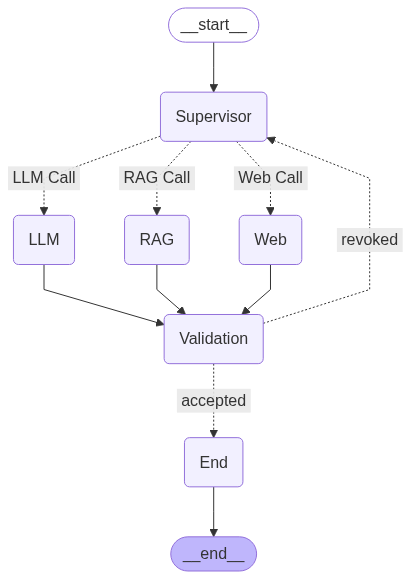

In [90]:
workflow.compile()

In [85]:
app = workflow.compile()


### test case 1

In [ ]:

state = {"messages": ["can you tell me the industrial growth of usa?"]}
result = app.invoke(state)

Question: can you tell me the industrial growth of usa?
Parsed response: Topic='USA' Reasoning='The query explicitly asks about the industrial growth of the USA.'
-->Router-->
last_message: USA
-> RAG Call ->
-> Validation Call ->
Validation result: is_valid=True reason='The answer directly addresses the question by describing the factors that contribute to the industrial growth of the U.S.'
-->Validation Router-->
is_valid: True
final_result:  The industrial growth of the U.S. is maintained through innovation, entrepreneurship, and investment in research and development. Its economy thrives on consumer spending, global trade, and financial services. Companies like Apple, Google, Amazon, Microsoft, and Tesla lead global markets.



### test case 2

In [88]:
#test case 2 
state = {"messages": ["tell me about current stocks"]}
result = app.invoke(state)

Question: tell me about current stocks
Parsed response: Topic='Web' Reasoning='Current stock prices are real-time data that requires access to the internet.'
-->Router-->
last_message: Web
-> Web Call ->
-> Validation Call ->
Validation result: is_valid=True reason='The answer directly addresses the question by providing information on current stock market indices and individual stocks.'
-->Validation Router-->
is_valid: True
final_result:  The Dow Jones Industrial Average is trading lower at 42,757.05 with a -0.01% change. Both the Nasdaq Composite Index and the S&P 500 Index are trading higher, with values of 19,631.74 and 6,019.70 respectively. Some individual stocks that are up include APA CORP, APTIV PLC, TESLA INC, CAESARS ENTERTAINMENT INC, DOW INC, and ENPHASE ENERGY INC.



### test case 3

In [ ]:

state = {"messages": ["hi"]}
result = app.invoke(state)

Question: hi
Parsed response: Topic='Not Related' Reasoning="The query 'hi' is a general greeting and does not relate to the USA or require web search for real-time information."
-->Router-->
last_message: Not Related
-> LLM Call ->
-> Validation Call ->
Validation result: is_valid=True reason='The answer directly addresses the question and is a complete sentence.'
-->Validation Router-->
is_valid: True
final_result:  Hi there! How can I help you today?

